<a href="https://colab.research.google.com/github/ohaijen/unet4nuclei/blob/master/BBBC039_Nucleus_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a toy notebook to try out the methods described in [this blog post](http://www.kubacieslik.com/developing-deep-learning-edge-detector-solve-toy-problem/#results). Specifically, we use the BSDS5000 dataset to train an edge detection model using TPUs. 

[This notebook](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_solution.ipynb#scrollTo=MPx0nvyUnvgT) was also the inspiration (ahem, source) for much of the code.

In [25]:
import sys
import os
from __future__ import print_function

import warnings

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imutils.paths import list_images
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.io import loadmat
from scipy.misc import imread
import skimage
from skimage.transform import resize


warnings.filterwarnings('ignore')
%matplotlib inline

print("Tensorflow version " + tf.__version__)

# Check that we're running on TPUs.
tpu = tf.contrib.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

Tensorflow version 1.13.1
Running on TPU  ['10.88.87.106:8470']


In [3]:
# Clone library for preprocessing images and boundary masks (cloned from the Carpenter lab's code accompanying the data).
!git clone https://github.com/ohaijen/unet4nuclei.git
!ls unet4nuclei/unet4nuclei/utils
sys.path.append(os.path.join("/content", 'unet4nuclei/unet4nuclei/utils'))
!ls /content/unet4nuclei/unet4nuclei/utils
import preprocessing

Cloning into 'unet4nuclei'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1363 (delta 0), reused 4 (delta 0), pack-reused 1357
Receiving objects: 100% (1363/1363), 234.06 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (786/786), done.
augmentation.py		  dirtools.py	 __init__.py	   objectives.py
contours_to_labels.ipynb  evaluation.py  metrics.py	   preprocessing.py
data_provider.py	  experiment.py  model_builder.py  visualize.py
augmentation.py		  dirtools.py	 __init__.py	   objectives.py
contours_to_labels.ipynb  evaluation.py  metrics.py	   preprocessing.py
data_provider.py	  experiment.py  model_builder.py  visualize.py
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_tf_examples', 'np', 'os', 'pathlib', 'preprocess_input_images', 'preprocess_output_masks', 'skimage', 'tf', 'tqdm']


In [5]:
# Download BBBC data. See https://data.broadinstitute.org/bbbc/BBBC039 for information about the dataset.
!curl https://data.broadinstitute.org/bbbc/BBBC039/images.zip --output /content/images.zip
!curl https://data.broadinstitute.org/bbbc/BBBC039/masks.zip --output /content/masks.zip
  
!unzip /content/masks.zip
!unzip /content/images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.3M  100 74.3M    0     0  7299k      0  0:00:10  0:00:10 --:--:-- 8004k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2689k  100 2689k    0     0  2102k      0  0:00:01  0:00:01 --:--:-- 2102k
Archive:  /content/masks.zip
   creating: masks/
  inflating: masks/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png  
   creating: __MACOSX/
   creating: __MACOSX/masks/
  inflating: __MACOSX/masks/._IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png  
  inflating: masks/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.png  
  inflating: __MACOSX/masks/._IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.png  
  inflating: masks/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.png  
  inflat

In [6]:
!mkdir /content/norm_images
!mkdir /content/boundary_labels

preprocessing.preprocess_input_images("/content/images/", "/content/norm_images/")
preprocessing.preprocess_output_masks("/content/masks/", "/content/boundary_labels/")

100%|██████████| 200/200 [00:17<00:00, 11.95it/s]

Total objects:  23615


In [0]:
#@title Run this cell - display utils.

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images in dataset:
      print(images.__class__)
      print(images.numpy().__class__)
      numpy_images, numpy_masks = images.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_masks = ses.run(get_next_item)

  return numpy_images, numpy_masks

def display_one_image(original, truth, position):
    plt.subplot(4, 4, position)
    plt.axis('off')
    plt.imshow(original)
    plt.title("Original", fontsize=16, color='black')
    plt.subplot(4, 4, position+1)
    plt.axis('off')
    plt.imshow(truth)
    plt.title("Truth", fontsize=16, color='black')
    return position+2

def display_one_prediction(position, original, prediction, truth):
    plt.subplot(5, 5, position)
    plt.axis('off')
    plt.imshow(original)
    plt.title("Original", fontsize=16, color='black')
    plt.subplot(5, 5, position+1)
    plt.axis('off')
    plt.imshow(prediction)
    plt.title("Prediction", fontsize=16, color='black')
    plt.subplot(5, 5, position+2)
    plt.axis('off')
    plt.imshow(truth)
    plt.title("Truth", fontsize=16, color='black')
    return position+5

def display_5_images_with_predictions(images, predictions, truth):
  subplot=1
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    subplot = display_one_prediction(subplot, image, predictions[i], truth[i])
    if i >= 4:
      break;
                
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.15)
  plt.show()

  
def display_8_images(images, boundaries):
  print("here!")
  subplot=1
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    subplot = display_one_image(image, boundaries[i], subplot)
    if i >= 7:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

(800, 256, 256)
(800, 256, 256, 3)
here!


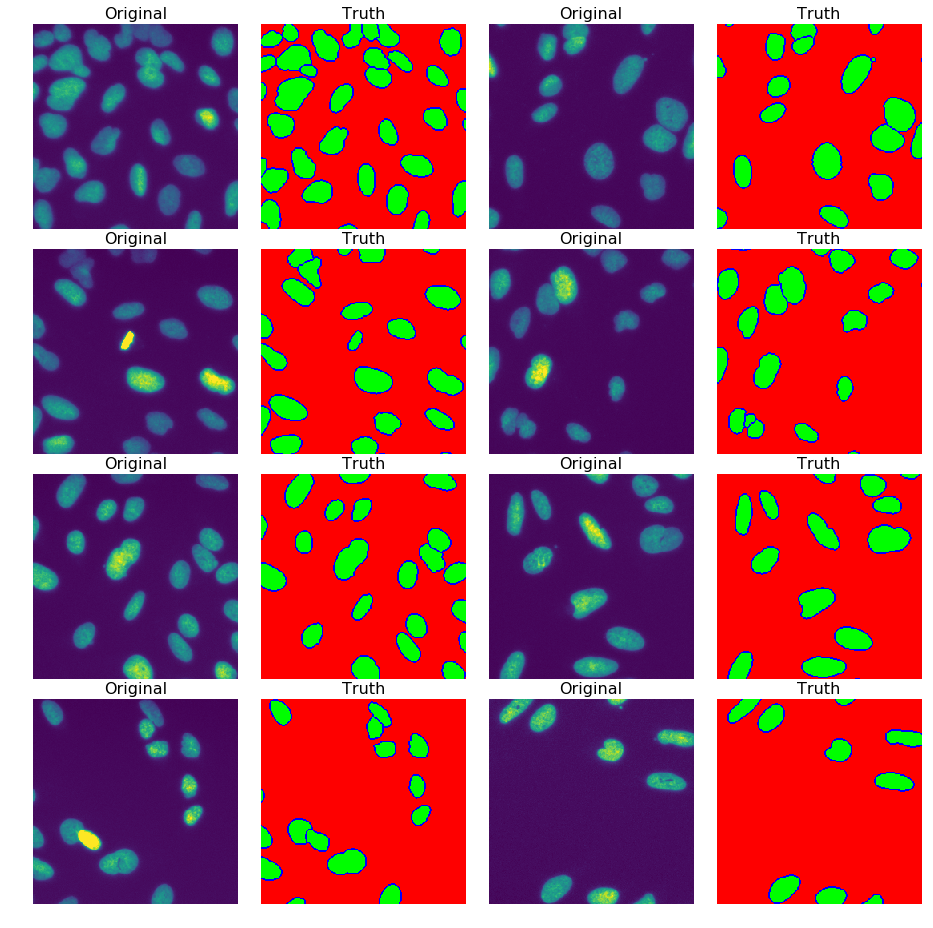

In [53]:
# Note that the entire training data fits easily into memory, so no need to get fancy about reading from disk.

files = os.listdir("/content/norm_images/")
files.sort()

# Read in the raw cell images and add a new axis to match TF shape expectations.
I = np.array([skimage.io.imread("/content/norm_images/" + filename) for filename in files])/256
print(I.shape)

C = np.array([skimage.io.imread("/content/boundary_labels/" + filename) for filename in files])/256
print(C.shape)

display_8_images(I, C)

In [0]:
# Define the most canonical of UNets. 

tf.keras.backend.set_image_data_format('channels_last')

from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose

def get_unet(img_rows, img_cols, channels):
    inputs = Input((img_rows, img_cols, channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    conv5 = Conv2DTranspose(512, kernel_size=2, strides=2)(conv5)  # Upsampling2D doesn't work with TPUs.
    up6   = Concatenate()([(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    conv6 = Conv2DTranspose(256, kernel_size=2, strides=2)(conv6)
    up7   = Concatenate()([conv6, conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    conv7 = Conv2DTranspose(128, kernel_size=2, strides=2)(conv7)
    up8   = Concatenate()([conv7, conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    conv8 = Conv2DTranspose(64, kernel_size=2, strides=2)(conv8)
    up9   = Concatenate()([conv8, conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=tf.train.AdamOptimizer(1e-3), 
                      loss='binary_crossentropy',
                      metrics=['binary_crossentropy'])

 

    return model

In [55]:
unet = get_unet(256, 256, 1)

tf.logging.set_verbosity(tf.logging.INFO)

csv_callback = tf.keras.callbacks.CSVLogger('history.log', append=True)

tpuunet = tf.contrib.tpu.keras_to_tpu_model(
    unet,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver()))

tpuunet.summary()

INFO:tensorflow:Querying Tensorflow master (grpc://10.88.87.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8909233306637329101)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4670837277856725758)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 787275237704072446)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18147709805900884321)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17178875089060456802)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/

In [0]:
csv_callback = tf.keras.callbacks.CSVLogger('history.log', append=True)

In [56]:
BATCH_SIZE = 128

validation_steps = int(3670 * .1 // BATCH_SIZE)
steps_per_epoch = int(3670 *.9 // BATCH_SIZE)
print(I.mean())
print(C.mean())

# A good number of epochs is maybe 50
history = tpuunet.fit(I[:,:,:,np.newaxis], C, verbose=2, epochs=50, validation_split=0.1, callbacks=[csv_callback])

0.11619171410799027
0.33203125
Train on 800 samples, validate on 80 samples
Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name='conv2d_37_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 19.483437061309814 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name='conv2d_37_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping place

dict_keys(['val_loss', 'val_binary_crossentropy', 'loss', 'binary_crossentropy'])


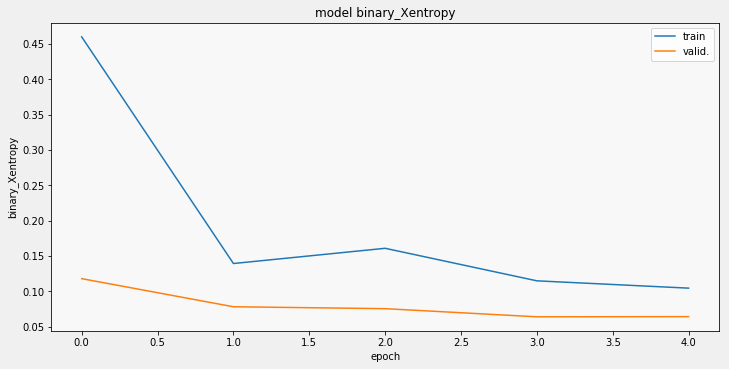

In [61]:
print(history.history.keys())
display_training_curves(history.history['binary_crossentropy'], history.history['val_binary_crossentropy'], 'binary_Xentropy', 211)

In [58]:
# Let's see what we got!

inference_unet = unet
inference_unet.set_weights(tpuunet.get_weights()) # this copies the weights from TPU to CPU

INFO:tensorflow:Copying TPU weights to the CPU


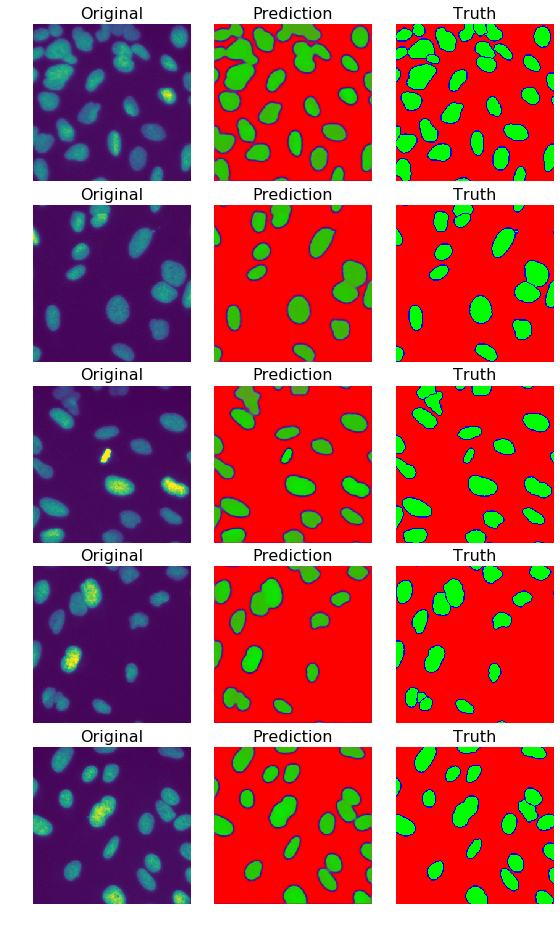

In [60]:
originals = (I[:40,:,:,np.newaxis])

predictions = inference_unet.predict(originals)

display_5_images_with_predictions(np.sum(originals, axis=3), predictions, C[:40])
